# Ingest web to raw
- Aquest Notebook guarda el codi i explicació de com ens conectem a la api de mercadona i guardem la informació dels productes de les diferents categories dins la capa `raw`.
- Al fitxer `Generacio dels conjunts de dades.pdf` es pot veure més informació al respecte. 

#### Que farem?
Necessitem crear aquesta esctuctura: 
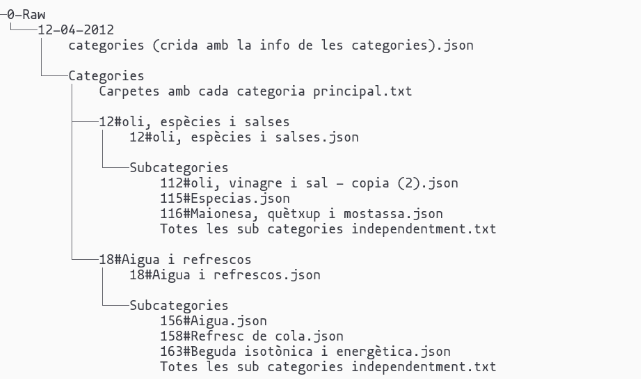

#### Pas a pas:
1. Crear una carpeta amb el dia d'avui (Ex: `13-04-2024`) a dins la carpeta `raw`
2. Cridar: https://tienda.mercadona.es/api/categories/?lang=ca
3. Dins la carpeta `13-04-2024`:
    - Guardar la resposta del punt 2 amb format .json
    - Crear una carpeta `categories`
4. A Dins de la carpeta `categories`:
    - Crear una carpeta amb nom: `id#name` per cada resultat (`response.results`) de la primera crida.
Primera crida:
```json
{
  "next": null,
  "count": 26,
  "results": [
    {
      "id": 12,
      "name": "Oli, espècies i salses",
      "order": 7,
      "layout": 2,
      "published": true,
      "categories": [
        {
          "id": 112,
          "name": "Oli, vinagre i sal",
          "order": 7,
          "layout": 1,
          "published": true,
          "is_extended": false
        },
...
```
5. A dins de cada carpeta anomenada: `id#name`:
    - Fer una crida al endpoint: https://tienda.mercadona.es/api/categories/id?lang=ca i guardar-hi la resposta en format .json
    - Crear una carpeta anomenada `subcategories`
6. A dins de `subcategories`
    - Per cada sub categoria que hi havia dins la primera crida `response.results.categories`, fer una nova crida amb la corresponent id i guardar la resposta amb el nom `id#nom`.
7. Repetir-ho per totes les categories.

#### Codi:

In [1]:
import os
import json
import requests
from datetime import datetime
from tqdm.notebook import tqdm

today = datetime.today().strftime('%d-%m-%Y')

def fetch(i=''):
    try:
        # Cridar api
        response = requests.get(f'https://tienda.mercadona.es/api/categories/{i}?lang=ca')

        # Error si la resposta no és 2xx
        response.raise_for_status()

        return response.json()

    except requests.exceptions.RequestException as e:
        print(f"Error al fer fetch: ", e)

def ingest_data():
    try:
        # Carpeta on s'executa el script actual
        path_actual = os.getcwd()

        # Ruta de la carpeta a crear
        path_carpeta = os.path.join(path_actual, '0-Raw', today)

        # Crear la carpeta si no existeix
        if not os.path.exists(path_carpeta):
            os.makedirs(path_carpeta)

        # Ruta del JSON
        path_json = os.path.join(path_carpeta, 'categories.json')

        # Fetch data
        data = fetch('')

        # Guardar JSON
        with open(path_json, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=4, ensure_ascii=False)

        # Crear la carpeta categories dins la carpeta de la data
        # Juntament amb el fitxer de categories que ja hem guardat
        path_carpeta = os.path.join(path_actual, '0-Raw', today, 'categories')

        if not os.path.exists(path_carpeta):
            os.makedirs(path_carpeta)

        # Per cada categoría, crear una carpeta amb el seu nom i a dins el fitxer raw,
        # la carpeta subcategories i tots els fixtxers raw de les subcategories
        for category in tqdm(data['results'], desc="Recollectant totes les categoríes"):

            category_path_name = f"{category['id']}#{category['name']}"
            path_carpeta = os.path.join(path_actual, '0-Raw', today, 'categories', category_path_name)

            if not os.path.exists(path_carpeta):
                os.makedirs(path_carpeta)

            path_json = os.path.join(path_carpeta, f'{category_path_name}.json')
            data = fetch(category['id'])

            with open(path_json, 'w', encoding='utf-8') as f:
                json.dump(data, f, indent=4, ensure_ascii=False)

            path_carpeta = os.path.join(path_actual, '0-Raw', today, 'categories', category_path_name, 'subcategories')
            if not os.path.exists(path_carpeta):
                os.makedirs(path_carpeta)

            for sub in data['categories']:
                path_json = os.path.join(path_carpeta, f"{sub['id']}#{sub['name']}.json")
                with open(path_json, 'w', encoding='utf-8') as f:
                    json.dump(data, f, indent=4, ensure_ascii=False)


    except Exception as e:
        print(f"Error: {e}")

# Ejecutar la función para ingestar los datos
ingest_data()

Recollectant totes les categoríes:   0%|          | 0/26 [00:00<?, ?it/s]